Si reviso `rmbsinbcn` noto que hay puntos que en realidad están dentro del municipio de Barcelona. Por tanto, lo que haré será:
1. Unir `rmbsinbcn` con `bcn`.
2. Eliminar duplicados de la base resultante.
3. Considerar como `bcn` sólo a los puntos que están dentro del municipio (basándome en el [shapefile](https://centrodedescargas.cnig.es/CentroDescargas/catalogo.do?Serie=CAANE)), lo que me dará el archivo `a-mun_bcn-marzo24.xlsx`.
4. Obtener una base para la RMB que sea `a-rmb-marzo24.xlsx`.

Además, luego he visto la oportunidad de obtener una base de datos para el Área Metropolitana de Barcelona (AMB), conformada por 36 municipios.

Así, finalmente tendré cuatro bases de datos: `a-prov_mad-marzo24.xlsx` (para toda la provincia), `a-amb_marzo24.xlsx`, `a-mun_bcn-marzo24.xlsx` (sólo el municipio) y `a-rmb-marzo24.xlsx`.

# Revisión inicial

In [1]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# Leer el DataFrame con las coordenadas
rmbsinbcn = pd.read_excel('data/pre-procesado/a-rmb-sin_bcn-marzo24-1.xlsx') 
bcn=pd.read_excel('data/pre-procesado/a-mun_bcn-marzo24-1.xlsx') 

#### RMB SIN BCN
# Convertir el DataFrame a un GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(rmbsinbcn['Lon_X'], rmbsinbcn['Lat_Y'])]
crs = {'init': 'epsg:4326'}  # Definir sistema de coordenadas WGS84
gdf_puntos = gpd.GeoDataFrame(rmbsinbcn, crs=crs, geometry=geometry)

# Convertir el GeoDataFrame a EPSG:32631
gdf_puntos = gdf_puntos.to_crs(epsg=32631)

#### BCN
# Convertir el DataFrame a un GeoDataFrame
geometry2 = [Point(lon, lat) for lon, lat in zip(bcn['Lon_X'], bcn['Lat_Y'])]
gdf_puntos2 = gpd.GeoDataFrame(bcn, crs=crs, geometry=geometry2)

# Convertir el GeoDataFrame a EPSG:32631
gdf_puntos2 = gdf_puntos2.to_crs(epsg=32631)

#### MUNICIPIOS
gdf_municipios = gpd.read_file('G:/Mi unidad/Datos/bcn/vectores/MUNICIPOS-ESPAÑA-31N.gpkg')

C:\Users\Usuari\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Usuari\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


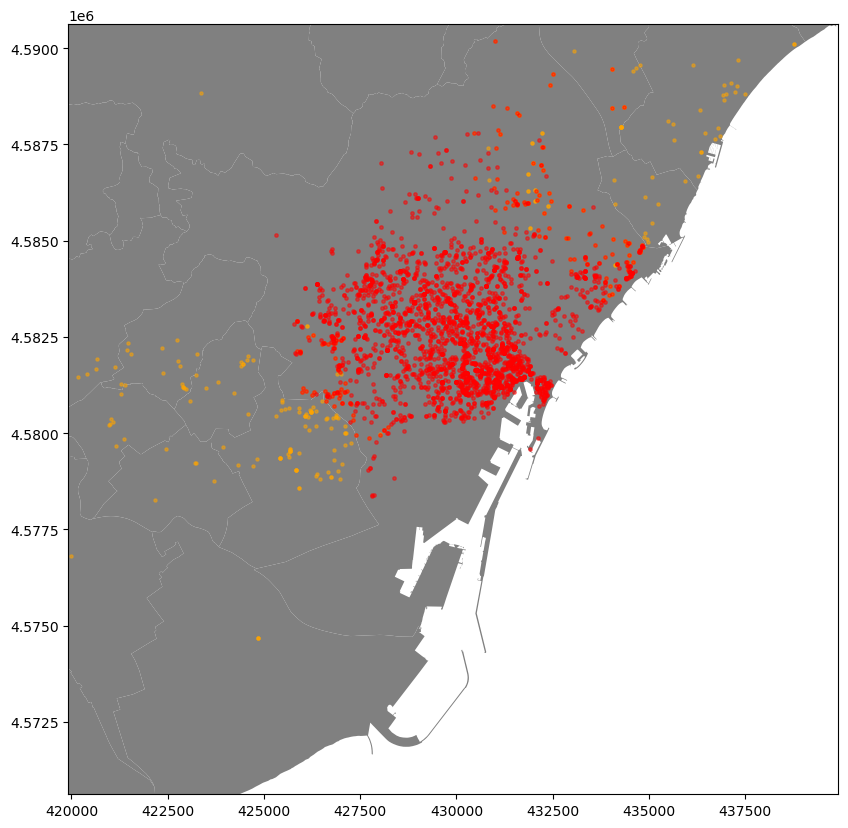

In [5]:
# Calcular el centro de los puntos
center_point = gdf_puntos2.geometry.unary_union.centroid

# Visualizar los datos centrados en los puntos
fig, ax = plt.subplots(figsize=(10, 10))
gdf_municipios.plot(ax=ax, color='gray')
gdf_puntos.plot(ax=ax, color='orange', markersize=5, alpha=0.5) ##Estos vienen de 'rmbsinbcn'
gdf_puntos2.plot(ax=ax, color='red', markersize=6, alpha=0.5) ##Estos vienen de 'bcn'
ax.set_xlim([center_point.x - 10000, center_point.x + 10000])  # Ajustar límites x para centrar en puntos
ax.set_ylim([center_point.y - 10000, center_point.y + 10000])  # Ajustar límites y para centrar en puntos
plt.show()

# 1. Unión de `bcn` con `rmbsinbcn`

In [6]:
# Concatenar los DataFrames uno debajo del otro
df = pd.concat([rmbsinbcn, bcn], axis=0)
len(df)

3797

# 2. Reviso duplicados

In [7]:
columns_to_keep = ['codigo_inmueble', 'Lon_X', 'Lat_Y']

# Crear una lista de columnas excluyendo las columnas que deseas mantener
columns_to_check_duplication = [col for col in df.columns if col not in columns_to_keep]

# Si quieres modificar directamente el DataFrame original, puedes hacer:
df.drop_duplicates(subset=columns_to_check_duplication, keep='first', inplace=True)

# Verificar el DataFrame resultante
len(df)

3797

Convierto el df a una versión georreferenciada.

In [8]:
# Convertir el DataFrame a un GeoDataFrame
geometry3 = [Point(lon, lat) for lon, lat in zip(df['Lon_X'], df['Lat_Y'])]
crs = {'init': 'epsg:4326'}  # Definir sistema de coordenadas WGS84
gdf_puntos3 = gpd.GeoDataFrame(df, crs=crs, geometry=geometry3)

# Convertir el GeoDataFrame a EPSG:25831
gdf_puntos3 = gdf_puntos3.to_crs(epsg=32631)

C:\Users\Usuari\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# 3. Nueva versión de `bcn`

In [9]:
gdf_municipios.head(1)

,INSPIREID,COUNTRY,NATLEV,NATLEVNAME,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,geometry
0,ES.IGN.BDDAE.34010404001,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34010404001,Abla,ES6,ES61,ES611,"MULTIPOLYGON (((-14292.138 4120932.645, -14246..."


In [10]:
gdf_filtrado = gdf_municipios[gdf_municipios['NAMEUNIT'] == 'Barcelona']

In [11]:
# Realizar una unión espacial entre los dos GeoDataFrames
nuevo_bcn = gpd.sjoin(gdf_puntos3, gdf_filtrado[['geometry']], how='inner', op='intersects')

C:\Users\Usuari\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [12]:
nuevo_bcn.head()

,Title,Link,precio_euros,codigo_inmueble,Description,last_mod,dummy_indice,indice_alquiler,area,n_rooms,...,lift,furniture,public_transp,barrio,codigo_inmueble_numero,Lat_Y,Lon_X,multifam,geometry,index_right
73,Alquiler Piso Carrer de sabino arana. Oportun...,https://www.habitaclia.com/alquiler-piso-oport...,1900,Anuncio: 26177004398072,OPORTUNIDAD PISO EN ZONA PRIVILEGIADAEdificio ...,07/03/2024,0,0.0,125,4,...,0,0,1,Sant Ramon,26177004398072,41.385743,2.124916,1,POINT (426834.500 4581949.040),5116
74,Alquiler Piso en Sant Ramon - Maternitat. Pi...,https://www.habitaclia.com/alquiler-piso-en_le...,1590,Anuncio: 5883004303283,"Piso semiamueblado en Les Corts, a un paso de...",21/03/2024,0,0.0,98,4,...,0,1,1,Sant Ramon,5883004303283,41.377647,2.114932,1,POINT (425990.536 4581058.733),5116
75,Alquiler Piso Avinguda de madrid. Piso de 4 h...,https://www.habitaclia.com/alquiler-piso-de_4_...,1800,Anuncio: 37701000000071,Apartamento en alquiler por un máximo de 11 me...,06/03/2024,0,0.0,90,4,...,0,1,0,Sant Ramon,37701000000071,41.377739,2.125850,1,POINT (426903.562 4581059.638),5116
76,Alquiler Piso en Avinguda de madrid 27. ¡ref...,https://www.habitaclia.com/alquiler-piso-refor...,1150,Anuncio: 12792003591115,Av. Madrid - Regent de Mendieta - ArizalaPreci...,19/03/2024,0,0.0,50,2,...,0,0,0,Sant Ramon,12792003591115,41.376831,2.124354,1,POINT (426777.485 4580960.146),5116
77,Alquiler Piso en Sant Ramon - Maternitat. Es...,https://www.habitaclia.com/alquiler-piso-espec...,2600,Anuncio: 8166003797592,"Propiedad en la calle Mejía Lequerica, con vis...",22/03/2024,1,17.9,164,5,...,0,0,0,Sant Ramon,8166003797592,41.383136,2.126011,1,POINT (426923.109 4581658.690),5116


In [13]:
len(nuevo_bcn)

3115

In [14]:
nuevo_bcn.drop(['geometry','index_right'],axis=1).to_excel('data/a-mun_bcn-marzo24.xlsx',index=False)

# 4. Obtengo la base de datos para el RMB

In [15]:
df.to_excel('data/a-rmb-marzo24.xlsx',index=False)

# 5. Obtengo la base de datos para la AMB

In [16]:
# Leer el archivo geopackage de municipios
gdf_amb = gpd.read_file('G:/Mi unidad/Datos/bcn/vectores/MUNICIPIOS-AMB-31N.gpkg')
gdf_amb = gdf_amb.to_crs(epsg=32631) #porque estaba mal seteado

# Realizar una unión espacial entre los dos GeoDataFrames
df_amb = gpd.sjoin(gdf_puntos3, gdf_amb[['geometry']], how='inner', op='intersects')

df_amb.head()

C:\Users\Usuari\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,Title,Link,precio_euros,codigo_inmueble,Description,last_mod,dummy_indice,indice_alquiler,area,n_rooms,...,lift,furniture,public_transp,barrio,codigo_inmueble_numero,Lat_Y,Lon_X,multifam,geometry,index_right
0,Alquiler Estudio en Collblanc,https://www.habitaclia.com/alquiler-estudio-co...,770,Anuncio: 48377000000745,RESERVAS E INQUIETUDESPara obtener información...,20/03/2024,0,0.0,25,0,...,0,0,0,Collblanc,48377000000745,41.372658,2.116238,1,POINT (426094.064 4580503.737),10
1,Alquiler Piso Carrer del montseny,https://www.habitaclia.com/alquiler-piso-la_to...,1180,Anuncio: 29091000000788,DISPONIBLE DESDE EL 15 DE MAYO DE 2024========...,15/03/2024,1,25.0,49,2,...,0,0,0,La Torrassa,29091000000788,41.369947,2.119384,1,POINT (426354.115 4580200.055),10
2,Alquiler Piso en Centre. Obra nueva en l'hos...,https://www.habitaclia.com/alquiler-piso-obra_...,1200,Anuncio: 5020003999800,*El reportaje fotográfico es una combinación d...,22/03/2024,0,0.0,72,2,...,0,0,0,Centre,5020003999800,41.359512,2.113287,1,POINT (425832.411 4579046.822),10
3,Alquiler Piso en Carrer de batllori 24. Camp...,https://www.habitaclia.com/alquiler-piso-campa...,1605,Anuncio: 48756000000012,"BEXT L´HOSPITALET, estrena un nuevo comienzo.Ú...",19/03/2024,0,0.0,88,3,...,0,0,0,Sant Josep,48756000000012,41.364323,2.111251,1,POINT (425667.552 4579582.630),10
4,Alquiler Dúplex en Carrer pi i margall 1. Du...,https://www.habitaclia.com/alquiler-duplex-obr...,2000,Anuncio: 49784000000012,En zona de Plaza Europa a 30 metros de la Boca...,01/03/2024,0,0.0,128,3,...,0,1,0,Santa Eulàlia,49784000000012,41.361919,2.124917,1,POINT (426807.839 4579304.137),10


In [17]:
len(df_amb)

3431

In [18]:
df_amb.drop(['geometry','index_right'],axis=1).to_excel('data/a-amb-marzo24.xlsx',index=False)

Para estar seguro de que las escalas son correctas, reviso la cantidad de datos para cada unidad de análisis.

In [20]:
print("Datos para el Municipio de Barcelona:",len(nuevo_bcn))
print("Datos para el AMB:",len(df_amb))
print("Datos para el RMB:",len(df))

Datos para el Municipio de Barcelona: 3115
Datos para el AMB: 3431
Datos para el RMB: 3797
